In [ ]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

try:
    import pyspark
except ImportError:
    import findspark
    findspark.init()
    import pyspark
    
    
# give notebook access to crymepipelines app modules
CRYMEPIPELINES_PATH = '/home/ben/.envs/cc/CrymeClarity/crymepipelines/src'
sys.path.insert(0, CRYMEPIPELINES_PATH)
sys.path.insert(1, CRYMEPIPELINES_PATH+'/tasks')


#build spark session
APP_NAME = 'CRYME_PIPELINE_DEV'
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()


In [ ]:
# import cyrmepipelines app modules
import csv
from datetime import datetime, timedelta
import os
import pickle as p
import shutil
from pyspark.sql.functions import udf, unix_timestamp
from pyspark.sql.types import StringType

from shared.objects.samples import SamplesManager
from shared.settings import CF_TRUST_DELAY, START_DATE, cf_conn, cp_conn, TMP_DIR, BIN_DIR
from tasks.base import SparkCrymeTask, NativeCrymeTask
from utils import crime_occ_udf, ts_to_minutes_in_day_udf, ts_to_hour_of_day_udf, ts_to_day_of_week_udf, ts_conv, safety_rel_crimes, actb_lat, actb_lon, space_dist
from tasks.mixins import SearchForCrimesMixin
from tasks.constants import crime_group_mapping

In [ ]:
crime_incidents = spark.read.parquet(CRYMEPIPELINES_PATH+'/tmp/features_crime_incidents.parquet')
loc_time_samples = SparkCrymeTask(spark).load_df_from_cp('location_time_samples')

In [ ]:
loc_time_samples = loc_time_samples.withColumn('lat_bb', actb_lat(loc_time_samples.latitude))
loc_time_samples = loc_time_samples.withColumn('lon_bb', actb_lon(loc_time_samples.longitude))
# convert datetime to unix timestamp
loc_time_samples = loc_time_samples.withColumn('timestamp_unix', unix_timestamp(loc_time_samples.timestamp))

In [ ]:
results = None
for i in range(-1, 2):
    for j in range(-1, 2):
        subsample = loc_time_samples.withColumn('lat_bb', loc_time_samples.lat_bb + i)
        subsample = subsample.withColumn('lon_bb', loc_time_samples.lon_bb + j)

        results_subsample = subsample.join(
            crime_incidents,
            (subsample.lat_bb == crime_incidents.lat_bb_c) & (subsample.lon_bb == crime_incidents.lon_bb_c)
        )

        results_subsample = results_subsample.filter(
            results_subsample.ts_occ_unix - results_subsample.timestamp_unix < 3600
        )
        results_subsample = results_subsample.filter(
            results_subsample.ts_occ_unix - results_subsample.timestamp_unix > 0
        )

        results_subsample = results_subsample.withColumn('distance', space_dist(
            results_subsample.longitude,
            results_subsample.latitude,
            results_subsample.lon,
            results_subsample.lat,
        ))

        results_subsample = results_subsample.filter(results_subsample.distance < .25)
        results = results.union(results_subsample) if results else results_subsample

In [ ]:
results = results.groupBy("id", "crm_grp").count()

In [ ]:
results = results.withColumn('n_ab', udf(lambda x: 1 if x == 'AB' else 0)(results.crm_grp))
results = results.withColumn('n_bt', udf(lambda x: 1 if x == 'BT' else 0)(results.crm_grp))
results = results.withColumn('n_btv', udf(lambda x: 1 if x == 'BTV' else 0)(results.crm_grp))
results = results.withColumn('n_vbbs', udf(lambda x: 1 if x == 'VBBS' else 0)(results.crm_grp))
results = results.withColumn('n_pdt', udf(lambda x: 1 if x == 'PDT' else 0)(results.crm_grp))
results = results.withColumn('n_ltvc', udf(lambda x: 1 if x == 'LTVC' else 0)(results.crm_grp))
results = results.withColumn('n_sp', udf(lambda x: 1 if x == 'SP' else 0)(results.crm_grp))
results = results.withColumn('n_mio', udf(lambda x: 1 if x == 'MIO' else 0)(results.crm_grp))
results = results.withColumn('n_r', udf(lambda x: 1 if x == 'R' else 0)(results.crm_grp))

In [ ]:
results = results.groupBy("id").agg({
    'n_ab': 'sum',
    'n_bt': 'sum',
    'n_btv': 'sum',
    'n_vbbs': 'sum',
    'n_pdt': 'sum',
    'n_ltvc': 'sum',
    'n_sp': 'sum',
    'n_mio': 'sum',
    'n_r': 'sum'
})

In [ ]:
dataset = loc_time_samples.join(results, "id", "left_outer")


In [ ]:
dataset = dataset.fillna(0, subset=['sum(n_mio)', 'sum(n_btv)', 'sum(n_vbbs)', 'sum(n_pdt)', 'sum(n_bt)',
                          'sum(n_ltvc)', 'sum(n_r)', 'sum(n_sp)','sum(n_ab)'])


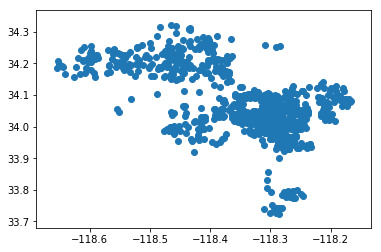

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.read_csv('/home/ben/.envs/cc/CrymeClarity/crymepipelines/src/tmp/complete_dataset.csv')
e = df[df['n_ab']>0]

plt.scatter(e.latitude, e.longitude)

In [17]:
e.shape

(957, 18)